# Ocean-Based Renewable Energy Generation

Visualizing electricity generation from marine and offshore wind by country over time

*Author: Rachel Thoms
<br>Created: 04 Aug 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- Vertical stacked bar chart
- Value is energy generation (gWh) for each technology (marine and offshore wind)
- One bar per year

## Data

- Data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (full dataset - [ene.009_renewable_generation_annually](https://resourcewatch.carto.com/u/wri-rw/dataset/ene_009_renewable_generation_annually_edit))
- Resource Watch: [explore page](https://resourcewatch.org/data/explore/1ed420e2-9283-4ced-b7b6-d5268be7a324)
- Source: [IRENA](https://www.irena.org/Statistics/Download-Data)

## Preparation

### Aliasing and Inserting Data

#### Queries

Individual Countries

``` SQL
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)
SELECT 'indicator' AS section, 'renewable energy generation' AS widget, alias.iso AS gid_0, alias.name_0 AS name_0, CONCAT(data.subtechnology, ' Energy') AS variable, data.year AS date, data.generation_gwh AS value, 'gWh' AS unit  
FROM (SELECT country_name, year, subtechnology, generation_gwh FROM "wri-rw".ene_009_renewable_generation_annually_edit WHERE (technology = 'Wind energy' AND subtechnology = 'Offshore Wind') OR technology = 'Marine energy') AS data
LEFT JOIN ow_aliasing_countries AS alias ON  data.country_name = alias.alias WHERE alias.iso IS NOT NULL
```

- countries with data: 28
- rows before: 152724
- rows inserted: 392
- rows after: 153116

World - Ocean

```sql
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)
SELECT 'indicator' AS section, 'renewable energy generation' AS widget, 'X01' AS gid_0, 'World' AS name_0, CONCAT(subtechnology, ' Energy') AS variable, year AS date, SUM(generation_gwh) AS value, 'gWh' AS unit FROM ene_009_renewable_generation_annually_edit WHERE (technology = 'Wind energy' AND subtechnology = 'Offshore Wind') OR technology = 'Marine energy' GROUP BY year, subtechnology
```

- rows before: 153116
- rows inserted: 38
- rows after: 153154

World - Total

Manually entered. Data from [Global Energy Statistical Yearbook](https://yearbook.enerdata.net/electricity/world-electricity-production-statistics.html)

- rows before: 153154
- rows inserted: 19
- rows after: 153173

### Vega

In [16]:
import json
from vega import Vega
from IPython.display import display

In [17]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [18]:
widget_width = 500
widget_height = 200

## Global Indicator Visualization

### Queries

#### Testing

```sql
SELECT date AS year, value, variable FROM ow_widget_territory AS data  
LEFT OUTER JOIN  gadm36_0 gadm ON data.gid_0 = gadm.gid_0 
WHERE section = 'indicator' AND widget = 'renewable energy generation' AND  variable != 'Total Energy' 
AND gadm.geostore_prod ILIKE 'f4599aaeedacb9e6ddca177a93795e4c' ORDER BY year ASC
```

```sql
SELECT date AS year, value, variable FROM ow_widget_territory AS data
LEFT OUTER JOIN  gadm36_0 gadm ON data.gid_0 = gadm.gid_0 
WHERE  section = 'indicator' AND widget = 'renewable energy generation' AND  variable != 'Total Energy' 
AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}' ORDER BY year ASC
```

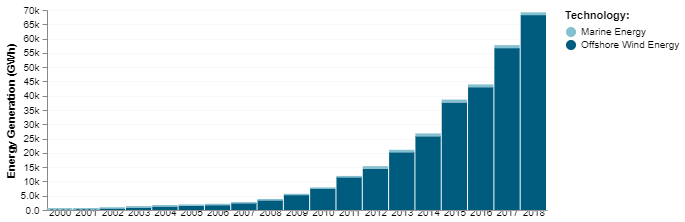

In [19]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "width": 500,
  "height": 200,
  "padding": 5,
  "signals": [
    {
      "name": "hover",
      "value": null,
      "on": [
        {"events": "@cell:mouseover", "update": "datum"},
        {"events": "@cell:mouseout", "update": "null"}
      ]
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT date AS year, value, variable FROM ow_widget_territory WHERE section = 'indicator' AND widget = 'renewable energy generation' AND  variable != 'Total Energy' AND gid_0 = 'GLB' ORDER BY year ASC",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {
          "type": "stack",
          "groupby": ["year"],
          "sort": {"field": "variable", "order": "descending"},
          "field": "value"
        }
      ]
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "band",
      "range": "width",
      "domain": {"data": "table", "field": "year"}
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "nice": true,
      "zero": true,
      "domain": {"data": "table", "field": "value"}
    },
    {
      "name": "color",
      "type": "ordinal",
      "range": ["#005c7e", "#84c0d0"],
      "domain": {"data": "table", "field": "variable"}
    },
    {
      "name": "legend",
      "type": "ordinal",
      "range": ["#84c0d0", "#005c7e"],
      "domain": ["Marine Energy", "Offshore Wind Energy"]
    }

  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "zindex": 0,
      "labelBaseline": "middle",
      "ticks": false,
      "labelFontSize": 10,
      "labelFont": "Arial"
    },
    {
      "orient": "left",
      "scale": "y",
      "zindex": 0,
      "title": "Energy Generation (GWh)",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 3,
      "grid": true,
      "gridOpacity": 0.2,
      "labelFontSize": 10,
      "labelFont": "Arial", 
      "encode":{
        "labels":{
          "update":{
            "text": {"signal": "format(datum.value, '.2s')"}
          }
        }
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "x": {"scale": "x", "field": "year"},
          "width": {"scale": "x", "band": 1, "offset": -1},
          "y": {"scale": "y", "field": "y0"},
          "y2": {"scale": "y", "field": "y1"},
          "fill": {"scale": "color", "field": "variable"},
          "tooltip": {
            "signal": "{'Technology':datum.variable,'Energy generation':format(round(datum.value),',') + ' GWh'}"
          }
        },
        "update": {"fillOpacity": {"value": 1}},
        "hover": {"fillOpacity": {"value": 0.5}}
      }
    }
  ],
  "legends": [{"title": ["Technology:"], "fill": "legend", "orient": "right"}]
}""")
vegaview=dict(spec)
Vega(vegaview)

## RW Backoffice

- [back office](https://resourcewatch.org/admin/data/widgets/3a6c3ff4-e1a5-4209-835d-40dabe37c1c5/edit?dataset=1ed420e2-9283-4ced-b7b6-d5268be7a324)
- parent dataset [ene_009](https://resourcewatch.org/data/explore/1ed420e2-9283-4ced-b7b6-d5268be7a324) 
- dataset id ```1ed420e2-9283-4ced-b7b6-d5268be7a324```
- widget id: ```3a6c3ff4-e1a5-4209-835d-40dabe37c1c5```